In [487]:
import torch # type: ignore
import torch.nn.functional as F # type: ignore
import matplotlib.pyplot as plt # type: ignore
%matplotlib inline

In [488]:
# Read data in a list.
words = open('names.txt', 'r').read().splitlines()
print(f"Total amount of words: {len(words)}")

Total amount of words: 32033


In [489]:
# Build the vocabulary of characters and mappings to/from integers.
chars = sorted(list(set(''.join(words))))
stoi = {ch: ix + 1 for ix, ch in enumerate(chars)}
stoi['.'] = 0
itos = {ix: ch for ch, ix in stoi.items()}

In [490]:
def plot_2d_characters(C: torch.tensor, size: int = 8) -> None:
    """
    Given a look-up table C of 2D character representations plot them on the grid.
    Args:
        C(torch.tensor, shape=[num_characters, 2]): Look-up table.
        size(int)                                 : Size of the plot.
    """
    vowels = ['a', 'e', 'i', 'o', 'u']  # list of all vowels in alphabet
    colors = ['red' if itos[ch] in vowels else 'blue' for ch in range(C.shape[0])]  # color vowels red
    colors[stoi['.']] = 'green'  # color '.' token green

    plt.figure(figsize=(size, size))
    plt.scatter(C[:, 0].data, C[:, 1].data, s=200, c=colors)
    for i in range(C.shape[0]):
        plt.text(C[i, 0].data, C[i, 1].data, itos[i], ha='center', va='center', color='white')
    plt.grid('minor')

In [491]:
def build_dataset(words: list[str], context_size: int = 3, logging: bool = False) -> tuple[torch.tensor]:
    """
    Given an list of string words, creates input and output targets.
    Args:
        words(list[int], shape=[n]): List of all words to sample examples from.
        context_size(int)          : How many characters are considered for prediction.
        logging(bool)              : Whether to print builded examples or not.
    Returns:
        X(torch.tensor, shape=[m, contex size]): Input tensor, where m is number of examples.
        Y(torch.tensor, shape=[m])             : Target tensor, where m is number of examples.
    """
    X, Y = [], []
    for word in words:
        context = [0] * context_size
        for ch in word + '.':
            X.append(context)
            Y.append(stoi[ch])
            context = context[1:] + [stoi[ch]]
    X, Y = torch.tensor(X), torch.tensor(Y)
    if logging:
        print(f'Input: {X.shape}, Output: {Y.shape}')
    return X, Y

---

In [663]:
# Model's hyperparameters
chs_amt = len(stoi)             # characters amount (27)
repr_dim = 27                    # characters representation deimensions 
cnx_size = 3                    # contex_size / characters considered for prediction 
ipt_size = repr_dim * cnx_size  # input size of a single example
W1_ns = 500                     # Amount of neurons in the first layer

In [664]:
import random
random.seed(13)
random.shuffle(words)
n1 = int(len(words) * 0.8)
n2 = int(len(words) * 0.9)

# Split data in Build, Development and Test sets.
Xtr, Ytr = build_dataset(words[:n1], cnx_size, True)
Xdev, Ydev = build_dataset(words[n1:n2], cnx_size, True)
Xte, Yte = build_dataset(words[n2:], cnx_size, True)

Input: torch.Size([182615, 3]), Output: torch.Size([182615])
Input: torch.Size([22831, 3]), Output: torch.Size([22831])
Input: torch.Size([22700, 3]), Output: torch.Size([22700])


In [665]:
# Initialize model
g = torch.Generator().manual_seed(13)
C = torch.randn(size=[chs_amt, repr_dim], generator=g)
W1 = torch.randn([ipt_size, W1_ns], generator=g)
b1 = torch.randn([W1_ns], generator=g)
W2 = torch.randn([W1_ns, chs_amt], generator=g) 
b2 = torch.randn([chs_amt], generator=g)

parameters = [C, W1, b1, W2, b2]
tot_prms = sum(p.nelement() for p in parameters)  # total amount of parameters in a model
# Tell torch to compute gradients for created parameters.
for p in parameters:
    p.requires_grad = True

In [666]:
"""Requires model and C-table initialization! Modifies global parameters!"""
def forward_pass(ipt_exmps: torch.tensor, tgt_exmps: torch.tensor) -> torch.tensor:
    """
    Given input parameters, input and target examples performs a forward pass and returns loss.
    Args:
        ipt_exmps(torch.tensor, shape=[m, ipt_size]): Input tensor, m - number of examples.
        tgt_exmps(torch.tensor, shape=[m])          : Target tensor, m - number of examples.
    Returns:
        loss(torch.tensor): evaluated loss.
    """
    emb = C[ipt_exmps]
    h = torch.tanh(emb.view(-1, ipt_size) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, tgt_exmps)
    return loss

In [667]:
# Place for tracking:
lri = []
lossi = []
stepi = []

In [668]:
# Learning hyperparameters
iters_num = 20000                  # number of iterations
lr = 0.1                     # learning rate
batch_size = 32               # size of the mini-batch
log_loss_step = False          # pring loss at each gradient step

In [669]:
for i in range(iters_num):
    if (i+1) % 5000 == 0:
        lr *= 0.6
        batch_size = int(batch_size*1.4)
    
    """Mini-batch construct"""
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    
    """Forward pass"""
    loss = forward_pass(Xtr[ix], Ytr[ix])
    if log_loss_step:
        print(loss.item())
    
    """Backward pass"""
    for p in parameters:
        p.grad = None
    loss.backward()
    
    """Update"""
    for p in parameters:
        p.data += -lr * p.grad
    
    """Track stats"""
    # lri.append(lre[i])
    lossi.append(loss.item())
    stepi.append(i)


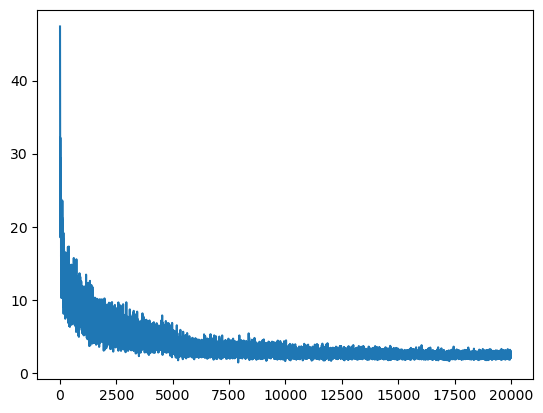

In [670]:
plt.plot(stepi, lossi)

In [671]:
train_loss = forward_pass(Xtr, Ytr)
dev_loss = forward_pass(Xdev, Ydev)
print(f"train: {train_loss}\ndevop: {dev_loss}")

train: 2.3752660751342773
devop: 2.5527639389038086
